# Using Topic Model to Analyze Radiology Reports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim import matutils

[nltk_data] Downloading package stopwords to /Users/sxy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Applications/anaconda2/envs/test/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load Dataset

In [68]:
# read data from the csv file
data = pd.read_csv("/Users/sxy/Documents/Cardiovascular3.csv", index_col=False)
print("Total Record:\t", len(data))
data.head()

Total Record:	 104


,Notes,Description
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.
1,1. The left ventricular cavity size and wall ...,2-D Echocardiogram
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2-D Echocardiogram
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Echocardiogram and Doppler
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",Transesophageal Echocardiogram. A woman admi...


In [69]:
# check basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Notes        104 non-null    object
 1   Description  104 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


## Data preprocessing

Since there are no missing data in this dataset, and it is difficult to define outlier in unstructured , we don't need to deal with this issue. In data preprocessing, we convert the word into lower case, split the word and drop stop words.

In [146]:
import re
# convert words into lowercase
data["Notes_new"] = data["Notes"].map(lambda x: x.lower())
# filter the colon
data["Notes_new"] = data["Notes_new"].map(lambda x: re.sub(r"[:.]", "", x))
data.head()

,Notes,Description,Notes_new,Topic
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.,"2-d m-mode , ,1 left atrial enlargement with ...",3
1,1. The left ventricular cavity size and wall ...,2-D Echocardiogram,1 the left ventricular cavity size and wall t...,3
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2-D Echocardiogram,"2-d echocardiogram,multiple views of the heart...",3
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Echocardiogram and Doppler,"description,1 normal cardiac chambers size,2 ...",3
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",Transesophageal Echocardiogram. A woman admi...,"history of present illness , i was kindly aske...",1


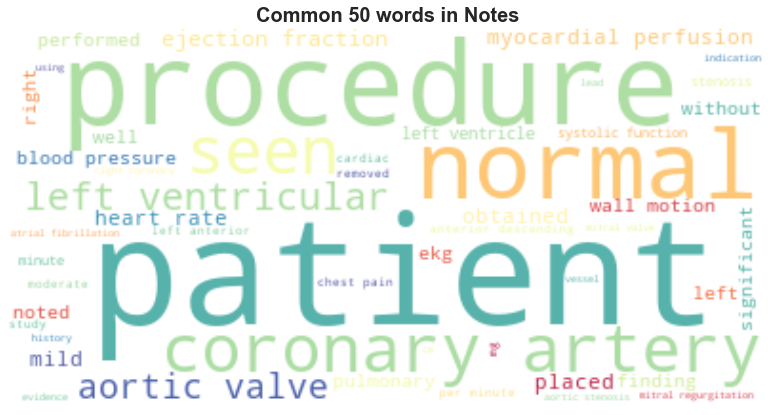

In [147]:
# use word cloud to show the frequencies of these words
# join the words together
long_string = ','.join(list(data.Notes_new.values))

# create a word cloud object
wordcloud = WordCloud(background_color="white", max_words=50, colormap="Spectral")

# generate a word cloud
wordcloud.generate(long_string)

# show the word cloud
plt.figure(figsize= (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Common 50 words in Notes", fontsize=20, weight = 'bold')

plt.show()

From the word cloud, we can observe that the word occurs most frequently is patient. It is intuitive since the notes are all about patient. However, patient doesn't have much meaning in this task, so we add it to stop words, and the same to procedure, left and right.

In [148]:
# drop stop words and extract lematized words
stop_words = stopwords.words('english')
stop_words.extend(["patient", "procedure", "left", "right"])
def extract_lemantized(text): 
    rev_text = nlp(text)
    # extract lematized words in lower case format if not digits, not punctuation, not stopword, length not less than 2, and noun, adj and adv
    rev_text = (",".join([token.lemma_.lower() for token in rev_text if not token.is_stop and token.text not in stop_words and not token.is_punct and len(token.text) > 3 and token.pos_ in ["NOUN", "ADJ", "ADV"]]))
    return rev_text
data["Notes_new"] = data["Notes_new"].apply(extract_lemantized)
data.head()

,Notes,Description,Notes_new,Topic
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.,"mode,atrial,enlargement,atrial,diameter,normal...",3
1,1. The left ventricular cavity size and wall ...,2-D Echocardiogram,"ventricular,cavity,size,wall,thickness,normal,...",3
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2-D Echocardiogram,"multiple,view,heart,great,vessel,normal,intrac...",3
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Echocardiogram and Doppler,"description,1,normal,cardiac,normal,normal,sys...",3
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",Transesophageal Echocardiogram. A woman admi...,"history,present,illness,kindly,performance,neu...",1


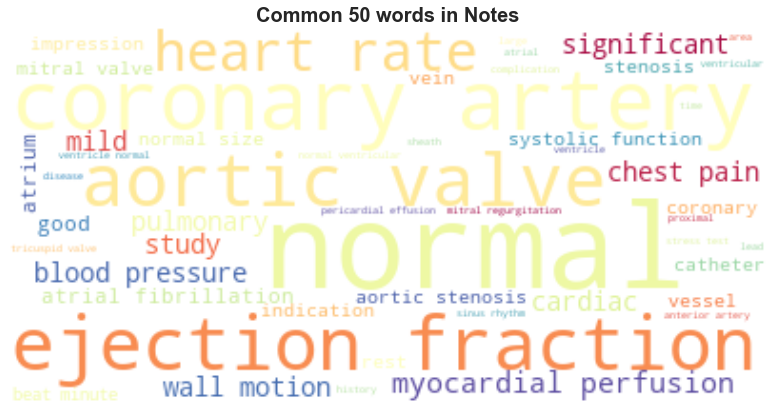

In [155]:
# Draw a word cloud again
long_string = ','.join(list(data.Notes_new.values))

# create a word cloud object
wordcloud = WordCloud(background_color="white", max_words=50, colormap="Spectral")

# generate a word cloud
wordcloud.generate(long_string)

# show the word cloud
plt.figure(figsize= (20,7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Common 50 words in Notes", fontsize=20, weight = 'bold')

plt.show()

In [153]:
import operator
# count the frequency of the top 20 words
counts = {}
for word in long_string.split(","):
    if word not in counts:
        counts[word] = 1
    else:
        counts[word] += 1
sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
counts = pd.DataFrame(sorted_counts[:20], columns=["Word", "Count"])
counts.head()

,Word,Count
0,normal,285
1,valve,201
2,artery,186
3,aortic,153
4,coronary,145


[]

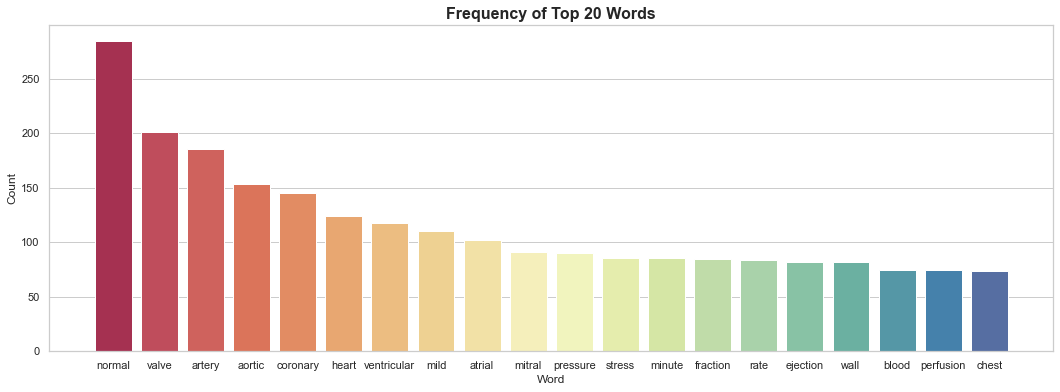

In [145]:
# plot the frequency
plt.figure(figsize=(18, 6))
sns.set_theme(style="whitegrid")
sns.barplot(data=counts, x="Word", y="Count", palette="Spectral", )
plt.title("Frequency of Top 20 Words", fontsize=16, weight="bold")
plt.plot()

After dropping stop words and extracting lematized words, normal becomes the most frequent word, and the words remained are mostly about organ and disease.

## Build LDA Model

In [92]:
# convert data to list for building dictionary
data["Notes_new"] = data["Notes_new"].apply(lambda x: x.split(","))

# create dictionary
id2word_1 = corpora.Dictionary(data["Notes_new"])

# create corpus: Term Document Frequency
corpus_1 = [id2word_1.doc2bow(review) for review in list(data["Notes_new"])]

 # build LDA model
ldamodel = LdaMulticore(corpus= corpus_1, num_topics =5, id2word=id2word_1, chunksize=2000, passes=50, per_word_topics=True)

## Results

In [93]:
# show the topic result
from pprint import pprint

pprint(ldamodel.show_topics(formatted=False))

[(0,
  [('artery', 0.058470186),
   ('coronary', 0.04473593),
   ('branch', 0.017384201),
   ('vessel', 0.015737044),
   ('catheter', 0.014072688),
   ('anterior', 0.011402003),
   ('femoral', 0.009652704),
   ('main', 0.009284045),
   ('stenosis', 0.008680944),
   ('wire', 0.0081757195)]),
 (1,
  [('atrial', 0.014316373),
   ('lead', 0.012748894),
   ('pacemaker', 0.009976531),
   ('chest', 0.00772935),
   ('risk', 0.0065209083),
   ('vein', 0.006364596),
   ('ventricular', 0.0060871392),
   ('heart', 0.0060694716),
   ('appropriate', 0.0057681184),
   ('pocket', 0.0056215506)]),
 (2,
  [('minute', 0.024329701),
   ('normal', 0.023456417),
   ('stress', 0.019680984),
   ('perfusion', 0.01843415),
   ('heart', 0.017456096),
   ('wall', 0.016002754),
   ('myocardial', 0.015222808),
   ('rate', 0.015182623),
   ('ventricular', 0.011545609),
   ('peak', 0.010356813)]),
 (3,
  [('valve', 0.04989304),
   ('normal', 0.040433917),
   ('aortic', 0.034909118),
   ('mitral', 0.022739615),
   ('m

In [127]:
# use pyLDAvis to show the results
# it is an interactive plot, if you can't see it, please run the code
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(ldamodel, corpus_1, id2word_1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.128673  0.209743       1        1  27.299016
2      0.152561  0.037953       2        1  22.245596
0     -0.149354 -0.133569       3        1  19.510859
1     -0.030206 -0.102299       4        1  17.872540
4      0.155672 -0.011827       5        1  13.071988, topic_info=          Term        Freq       Total Category  logprob  loglift
31      artery  162.000000  162.000000  Default  30.0000  30.0000
25       valve  179.000000  179.000000  Default  29.0000  29.0000
83    coronary  126.000000  126.000000  Default  28.0000  28.0000
2       aortic  136.000000  136.000000  Default  27.0000  27.0000
12      mitral   81.000000   81.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
79        wall   10.796130   72.046439   Topic5  -4.9846   0.1366
5    diastolic    7.879776   20.520517   Topic5  -5.2995   1.0776
57      motion    8.366976   39.860715   Topic5  -5.2395   0.4736
22    systolic    8.396147   60.285911   Topic5  -5.2360   0.0634
245      sinus    7.617236   36.823107   Topic5  -5.3334   0.4590

[332 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
27        1  0.120532  abnormal
27        2  0.723193  abnormal
27        3  0.060266  abnormal
27        5  0.060266  abnormal
1038      3  0.145972    access
...     ...       ...       ...
783       2  0.915742    window
1104      3  0.687567      wire
1104      4  0.289502      wire
692       2  0.915742      word
513       2  0.915742  workload

[530 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

We calculate 5 topics and 10 typical words for each topic. Normal appears in 3 topics, topic 2, 3 and 4. The other words in these three topics are usually organ. In my opinion, it indicates that the organ in these topics are normal. In topic 1, lead is usually followed by bad news and risk also appears. In my interpretation, it indicates that the patient is at risk, and the risk factor might relate to atrial, chest, vein and ventricular. We will randomly pick some data cases and check it.

In [104]:
# pick the topic with biggest probability for each note
def add_topic(text):
    doc_bow = id2word_1.doc2bow(text)      
    doc_lda = ldamodel[doc_bow]
    topics = doc_lda[0]
    topic = sorted(topics, key=lambda x:x[1])[-1]
    return topic[0]
data["Topic"] = data["Notes_new"].apply(add_topic)
data.head()

,Notes,Description,Notes_new,Topic
0,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2-D M-Mode. Doppler.,"[mode, atrial, enlargement, atrial, diameter, ...",3
1,1. The left ventricular cavity size and wall ...,2-D Echocardiogram,"[ventricular, cavity, size, wall, thickness, n...",3
2,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2-D Echocardiogram,"[multiple, view, heart, great, vessel, normal,...",3
3,"DESCRIPTION:,1. Normal cardiac chambers size....",Echocardiogram and Doppler,"[description, 1, normal, cardiac, normal, norm...",3
4,"HISTORY OF PRESENT ILLNESS: , I was kindly ask...",Transesophageal Echocardiogram. A woman admi...,"[history, present, illness, kindly, performanc...",1


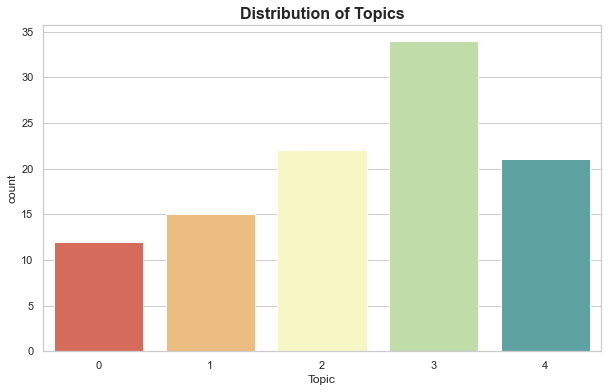

In [144]:
# draw the distribution of topics
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x="Topic", data=data, palette="Spectral")
plt.title("Distribution of Topics", fontsize=16, weight="bold")
plt.show()

In [96]:
print("Origninal notes: %s" %data["Notes"][55])
test_doc=data["Notes_new"][55]
doc_bow = id2word_1.doc2bow(test_doc)      
doc_lda = ldamodel[doc_bow]
print("Topic: %s" %doc_lda[0])

Origninal notes: INDICATIONS:,  Atrial fibrillation, coronary disease.,STRESS TECHNIQUE:, The patient was infused with dobutamine to a maximum heart rate of 142.  ECG exhibits atrial fibrillation.,IMAGE TECHNIQUE:,  The patient was injected with 5.2 millicuries of thallous chloride and subsequently imaged on the gated tomographic SPECT system.,IMAGE ANALYSIS:,  It should be noted that the images are limited slightly by the patient's obesity with a weight of 263 pounds.  There is normal LV myocardial perfusion.  The LV systolic ejection fraction is normal at 65%.  There is normal global and regional wall motion.,CONCLUSIONS:,1.  Basic rhythm of atrial fibrillation with no change during dobutamine stress, maximum heart rate of 142.,2.  Normal LV myocardial perfusion.,3.  Normal LV systolic ejection fraction of 65%.,4.  Normal global and regional wall motion.
Topic: [(4, 0.9860272)]


From the notes, we can observe that the condition of this patient is normal and the topic of this note is topic 4.

In [124]:
print("Origninal notes: %s" % data["Notes"][41])
test_doc=data["Notes_new"][41]
doc_bow = id2word_1.doc2bow(test_doc)      
doc_lda = ldamodel[doc_bow]
print("Topic: %s" %doc_lda[0])

Origninal notes: PROCEDURE PERFORMED:,  Insertion of a VVIR permanent pacemaker.,COMPLICATIONS:,  None.,ESTIMATED BLOOD LOSS: , Minimal.,SITE:,  Left subclavian vein access.,INDICATION: , This is an 87-year-old Caucasian female with critical aortic stenosis with an aortic valve area of 0.5 cm square and recurrent congestive heart failure symptoms mostly refractory to tachybrady arrhythmias and therefore, this is indicated so that we can give better control of heart rate and to maintain beta-blocker therapy in the order of treatment.  It is overall a Class-II indication for permanent pacemaker insertion.,PROCEDURE:,  The risks, benefits, and alternative of the procedure were all discussed with the patient and the patient's family in detail at great length.  Overall options and precautions of the pacemaker and indications were all discussed.  They agreed to the pacemaker.  The consent was signed and placed in the chart.  The patient was taken to the Cardiac Catheterization Lab, where she

From this case, the patient is at risk, and the note belongs to topic 1.